In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import os
from scipy.optimize import curve_fit

NO_MS_EQUALS_1 = 0
Q_FINAL = 1
THREE_PI_HALF_FINAL = 2
REF_MINUS_SIG  =3

In [2]:
def sinusoid(t, A, Tpi, phi,C):
    return A*np.cos(np.pi/Tpi*t + phi) + C

def sinusoidDecay(t, A, Tpi, phi,C, T2):
    return A*np.cos(np.pi/Tpi*t + phi)*np.exp(-t/T2) + C

def fitSinusoid(xdata, ydata, guess=None):
    lowerBounds = (0,0,-np.pi, -np.inf)
    upperBounds = (np.inf, np.inf, np.pi, np.inf)
    popt, pcov = curve_fit(sinusoid, xdata, ydata, p0=guess, bounds=(lowerBounds, upperBounds))
    perr = np.sqrt(np.diag(pcov))
    xfit = np.linspace(xdata[0], xdata[-1], 1001)
    yfit = sinusoid(xfit, *popt)
    return xfit, yfit, popt, perr

def fitSinusoidDecay(xdata, ydata, guess=None):
    lowerBounds = (0,0,-np.pi, -np.inf,0)
    upperBounds = (np.inf, np.inf, np.pi, np.inf, np.inf)
    popt, pcov = curve_fit(sinusoidDecay, xdata, ydata, p0=guess, bounds=(lowerBounds, upperBounds))
    perr = np.sqrt(np.diag(pcov))
    xfit = np.linspace(xdata[0], xdata[-1], 1001)
    yfit = sinusoidDecay(xfit, *popt)
    return xfit, yfit, popt, perr


def readData(datafile, type=None, typeNorm=0, guess=None):
    readfile = np.loadtxt(datafile)
    
    x_s = [xAxisAndResult[0] for xAxisAndResult in readfile]
    ref = [xAxisAndResult[1] for xAxisAndResult in readfile]
    sig = [xAxisAndResult[2] for xAxisAndResult in readfile]

    x_s = np.array(x_s)
    if type == 'XY8': x_s = 8*x_s

    fig,ax = plt.subplots()
    ax.plot(x_s, sig, 'o-', label='sig', color='C0')
    ax.plot(x_s, ref, 'o-', label='ref', color = 'C1')
    ax.legend(loc='best')
    ax.set_xlabel(r"$\tau$ (ns)")

    sig = np.array(sig); ref = np.array(ref); sigOverRef = sig/ref; 

    fig2,ax = plt.subplots()
    if typeNorm == NO_MS_EQUALS_1:
        ax.plot(x_s, sigOverRef, 'o-', label='sig/ref', color='C0')
    elif typeNorm == Q_FINAL or typeNorm == THREE_PI_HALF_FINAL:
        ax.plot(x_s, (sig-ref)/(sig+ref), 'o-', label='(sig-ref)/(sig+ref)', color='C0')
    elif typeNorm == REF_MINUS_SIG:
        ax.plot(x_s, -(sig-ref)/(sig+ref), 'o-', label='(sig-ref)/(sig+ref)', color='C0')
    ax.legend(loc='best')
    ax.set_xlabel(r"$\tau$ (ns)")

    if type == 'Rabi':
        xfit, yfit, popt, perr = fitSinusoid(x_s, sigOverRef, guess=guess)
        print(popt)
        ax.plot(xfit, yfit, color='C1')
        ax.set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]))
    
    elif type == 'RabiDecay':
        xfit, yfit, popt, perr = fitSinusoidDecay(x_s, sigOverRef, guess=guess)
        print(popt)
        ax.plot(xfit, yfit, color='C1')
        ax.set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]))

    
    plt.show()

def readDataSoftAvg(dateFolder, indices, type=None, typeNorm=0):
    sig = []; ref = []
    for idx in indices:
        for root, dirs, files in os.walk(dateFolder):
            for dataFolder in dirs:
                idxString = str(int(idx)) + '_'
                if idxString in str(dataFolder):
                    dataFolderPath = dateFolder + dataFolder + '/'
                    for root2, dirs2, files2 in os.walk(dataFolderPath):
                        for name in files2:
                            if name.endswith((".dat")):
                                datafile = dataFolderPath + name
                                print(datafile)

                                readfile = np.loadtxt(datafile)
                                # print(readfile)
                                x_s = [xAxisAndResult[0] for xAxisAndResult in readfile]
                                ref += [xAxisAndResult[1] for xAxisAndResult in readfile]
                                sig += [xAxisAndResult[2] for xAxisAndResult in readfile]

                                sig = np.array(sig); ref = np.array(ref); sigOverRef = sig/ref; x_s = np.array(x_s)
   
    fig,ax = plt.subplots()
    ax.plot(x_s, sig, 'o-', label='sig', color='C0')
    ax.plot(x_s, ref, 'o-', label='ref', color = 'C1')
    ax.legend(loc='best')
    ax.set_xlabel(r"$\tau$ (ns)")

    
    fig2,ax = plt.subplots()
    if typeNorm == NO_MS_EQUALS_1:
        ax.plot(x_s, sigOverRef, 'o-', label='sig/ref', color='C0')
    elif typeNorm == Q_FINAL or typeNorm == THREE_PI_HALF_FINAL:
        ax.plot(x_s, (sig-ref)/(sig+ref), 'o-', label='(sig-ref)/(sig+ref)', color='C0')
    ax.legend(loc='best')
    ax.set_xlabel(r"$\tau$ (ns)")

    if type == 'Rabi':
        guess=(0.2, 50, 0, 0.9)
        xfit, yfit, popt, perr = fitSinusoid(x_s, sigOverRef, guess=guess)
        print(popt)
        ax.plot(xfit, yfit, color='C1')
        # ax.plot(xfit, sinusoid(xfit, *guess), color='C2')
        ax.set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]))
    
    plt.show()

def readDataConcatenate(dateFolder, indices, type=None, typeNorm=0):
    x_s_all = []; sig_all = []; ref_all = []
    for idx in indices:
        for root, dirs, files in os.walk(dateFolder):
            for dataFolder in dirs:
                idxString = str(int(idx)) + '_'
                if idxString in str(dataFolder):
                    dataFolderPath = dateFolder + dataFolder + '/'
                    for root2, dirs2, files2 in os.walk(dataFolderPath):
                        for name in files2:
                            if name.endswith((".dat")):
                                datafile = dataFolderPath + name
                                print(datafile)

                                readfile = np.loadtxt(datafile)
                                # print(readfile)
                                x_s = [xAxisAndResult[0] for xAxisAndResult in readfile]
                                ref = [xAxisAndResult[1] for xAxisAndResult in readfile]
                                sig = [xAxisAndResult[2] for xAxisAndResult in readfile]

                                sig = np.array(sig); ref = np.array(ref); sigOverRef = sig/ref; x_s = np.array(x_s)
                                x_s_all = np.concatenate((x_s_all, x_s))
                                sig_all = np.concatenate((sig_all, sig))
                                ref_all = np.concatenate((ref_all, ref))
   
    fig,ax = plt.subplots()
    ax.plot(x_s_all, sig_all, 'o-', label='sig', color='C0')
    ax.plot(x_s_all, ref_all, 'o-', label='ref', color = 'C1')
    ax.legend(loc='best')
    ax.set_xlabel(r"$\tau$ (ns)")

    
    fig2,ax = plt.subplots()
    if typeNorm == NO_MS_EQUALS_1:
        ax.plot(x_s_all, sig_all/ref_all, 'o-', label='sig/ref', color='C0')
    elif typeNorm == Q_FINAL or typeNorm == THREE_PI_HALF_FINAL:
        ax.plot(x_s_all, (sig_all-ref_all)/(sig_all+ref_all), 'o-', label='(sig-ref)/(sig+ref)', color='C0')
    ax.legend(loc='best')
    ax.set_xlabel(r"$\tau$ (ns)")

    plt.show()

def readDataSigMinusRef(datafile):
    readfile = np.loadtxt(datafile)
    # print(readfile)
    x_s = [xAxisAndResult[0] for xAxisAndResult in readfile]
    ref = [xAxisAndResult[1] for xAxisAndResult in readfile]
    sig = [xAxisAndResult[2] for xAxisAndResult in readfile]
    sigOverRef = [xAxisAndResult[3] for xAxisAndResult in readfile]

    # fig,ax = plt.subplots()
    # ax.plot(x_s, sig, label='sig')
    # ax.plot(x_s, ref, label='ref')
    # ax.legend(loc='best')
    # ax.set_xlabel(r"$\tau$ (ns)")
    # ax.set_title(datafile[43:46])

    sig = np.array(sig); ref = np.array(ref)
    fig,ax = plt.subplots()
    ax.plot(x_s, sig-ref, label='sig-ref')
    # ax.plot(x_s, ref/sig-np.average(ref/sig), label='sig-ref')
    ax.legend(loc='best')
    ax.set_xlabel(r"$\tau$ (ns)")
    return fig

def readDataNoPlot(datafile):
    readfile = np.loadtxt(datafile)
    # print(readfile)
    x_s = [xAxisAndResult[0] for xAxisAndResult in readfile]
    ref = [xAxisAndResult[1] for xAxisAndResult in readfile]
    sig = [xAxisAndResult[2] for xAxisAndResult in readfile]
    
    return x_s, sig, ref

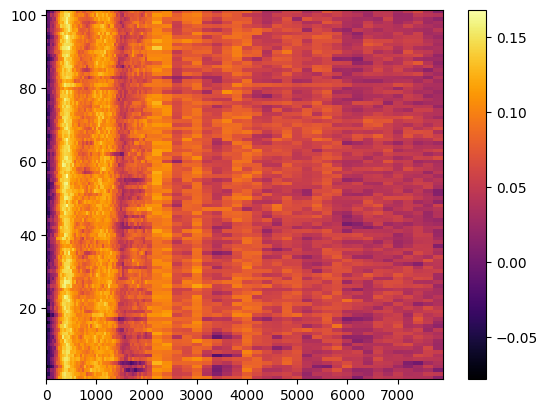

In [3]:
# mainFolder = 'C:/Users/lukin2dmaterials/data/2022-12-19/'
days = np.linspace(16,31,16)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2022-12-' + str(int(day)) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2E' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx > 0:
                datafile = mainFolder + dataFolder +'/T2EObject_sig_set.dat'
                x_s, sig, ref = readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                n = 80
                x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                contrast = (sig-ref)/(sig+ref)
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')

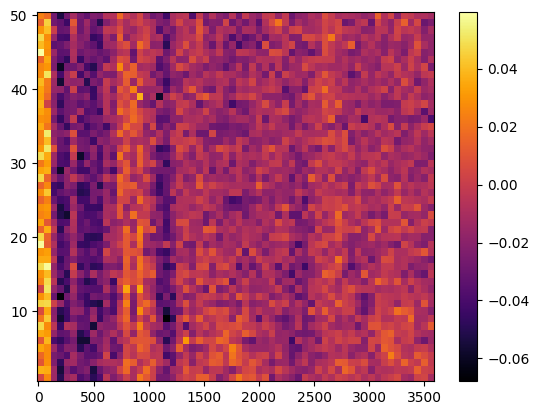

In [4]:
# mainFolder = 'C:/Users/lukin2dmaterials/data/2022-12-19/'
days = np.linspace(16,31,16)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2022-12-' + str(int(day)) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'XY8' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx >= 0:
                datafile = mainFolder + dataFolder +'/XY8Object_sig_set.dat'
                x_s, sig, ref = readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                n = 60
                x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                contrast = (sig-ref)/(sig+ref)
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')

In [ ]:
mainFolder = 'C:/Users/lukin2dmaterials/data/2023-03-06/'
for dataFolder in os.listdir(mainFolder):
    # print(dataFolder)
    if 'T2E' in dataFolder:
        idx = int(dataFolder[1:4])
        if idx > 0:
            datafile = mainFolder + dataFolder +'/T2EObject_sig_set.dat'
            fig = readData(datafile, type='T2E', typeNorm=1)

In [ ]:
mainFolder = 'C:/Users/lukin2dmaterials/data/2023-01-31/'
for dataFolder in os.listdir(mainFolder):
    # print(dataFolder)
    if 'XY8' in dataFolder:
        idx = int(dataFolder[1:4])
        if idx > 0:
            datafile = mainFolder + dataFolder +'/XY8Object_sig_set.dat'
            fig = readData(datafile, type='XY8', typeNorm=1)

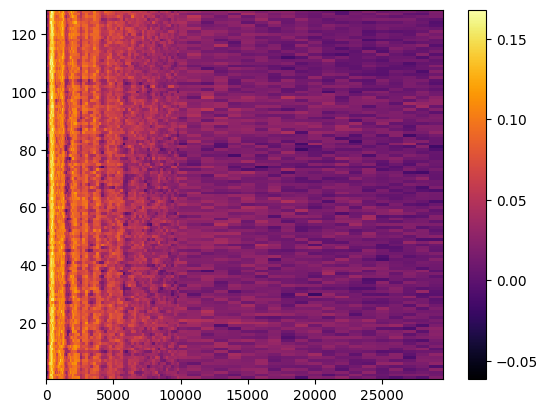

In [12]:
# mainFolder = 'C:/Users/lukin2dmaterials/data/2022-12-19/'
days = np.concatenate((np.linspace(1,13,13),np.linspace(29,31,3)))
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-01-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2E' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx > 0:
                datafile = mainFolder + dataFolder +'/T2EObject_sig_set.dat'
                x_s, sig, ref = readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                n = 110
                x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                contrast = (sig-ref)/(sig+ref)
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')

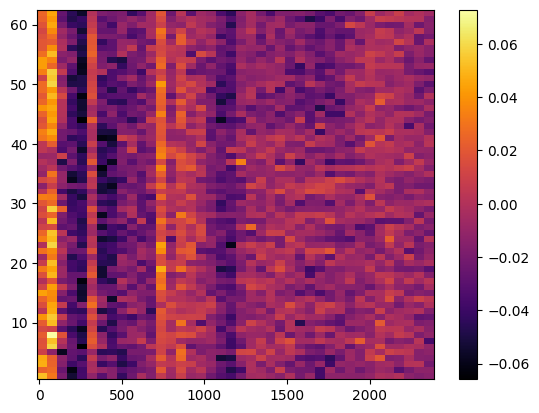

In [19]:
# mainFolder = 'C:/Users/lukin2dmaterials/data/2022-12-19/'
days = np.concatenate((np.linspace(1,13,13),np.linspace(29,31,3)))
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-01-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'XY8' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx > 0:
                datafile = mainFolder + dataFolder +'/XY8Object_sig_set.dat'
                x_s, sig, ref = readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                n = 40
                x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                contrast = (sig-ref)/(sig+ref)
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')

C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_22844\3528501571.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataArr = np.array(dataArr)


ValueError: not enough values to unpack (expected 2, got 1)

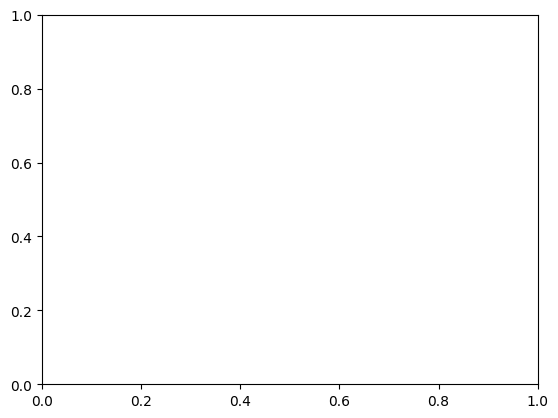

In [4]:
# mainFolder = 'C:/Users/lukin2dmaterials/data/2022-12-19/'
days = np.linspace(11,20,10)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-02-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2E' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx > 0:
                datafile = mainFolder + dataFolder +'/T2EObject_sig_set.dat'
                x_s, sig, ref = readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                n = -1
                x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                contrast = (sig-ref)/(sig+ref)
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')